In [1]:
# test likelihood notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mfpy import CrossSpectrum, WindowFunction

In [3]:
def pad_arr_ell2(arr):
    """Adds two columns of zeros to a 2D array on the last dimension."""
    result_size = np.array(arr.shape)
    result_size[-1] += 2
    result = np.zeros(result_size)
    result[...,2:] = arr
    return result

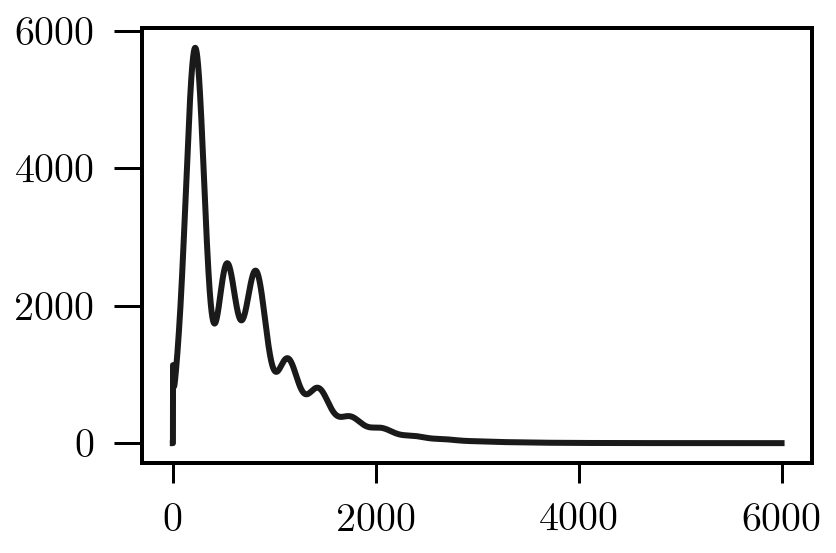

In [5]:
l_max = 6000
filename = 'data/wmap7_act_lcdm_bestfit_lensedCls_6000.dat'
data = np.genfromtxt(filename, unpack=True, usecols=(0,1),
                     dtype=[('ell', '<i8'),('cltt', '<f8')])
cl_th = pad_arr_ell2(data['cltt'])
plt.plot(cl_th)

In [410]:
# %% initialize cross spectra
from itertools import product

root_dir = 'data/data_act/equa/'
freqs = ('148', '220')
get_freq_ind = { '148' : 0, '220' : 1 }
seasons = ('3e', '4e')

# read spectra and windows
spectra, windows, window_ells = {}, {}, {}
cross_list = []
Nbins = 0 # counter for number of spectra bins

for f1, f2, s1, s2 in product(freqs, freqs, seasons, seasons):
    # some spectra are redundant, see Das et al 2013 Sec 4.4
    if (not (f1 == '220' and f2 == '148') and
        (not (s1 == '4e' and s2 == '3e') or f1 != f2)):
        cross_list.append( (f1, f2, s1, s2) )
        specfile = f'{root_dir}spectrum_{f1}x{f2}_season{s1}xseason{s2}.dat'
        winfile = f'{root_dir}BblMean_{f1}x{f2}_season{s1}xseason{s2}.dat'
        
        # store all the data from files into the dictionaries
        spec_l_min = 500 if (f1=='148' and f2=='220') else 1500
        spec_l_max = min(l_max, 10000)
        ell, cl, nl = np.genfromtxt(specfile, unpack=True)
        spectra[(f1, f2, s1, s2)] = CrossSpectrum(
            ell[ell<l_max], cl[ell<l_max], 
            l_min=spec_l_min, l_max=spec_l_max, noise=nl[ell<l_max])
        Nbins += len(ell)
        
        # first column of win_data is ells, rest is matrix
        win_data = np.genfromtxt(winfile).T
        windows[(f1, f2, s1, s2)] = WindowFunction(
            ell=np.arange(l_max+1), 
            window=pad_last_ell(win_data[1:,:l_max-1]))
        

bin_left, bin_right, bin_center = np.genfromtxt(
    f'{root_dir}binningFile.dat', unpack=True)
invcov = np.genfromtxt(f'{root_dir}Inverse_Realistic_Cov_Mat_Equa.dat')
invcov = np.reshape(invcov, (Nbins, Nbins))
cov = np.load(f'{root_dir}Cov_Mat_Equa.npy')

In [411]:
import fgspectra.models

# define a list of components
components = [
    fgspectra.models.ThermalSZ(),
    fgspectra.models.KinematicSZ(),
    fgspectra.models.CIBP(),
    fgspectra.models.CIBC(),
    fgspectra.models.tSZxCIB(),
    fgspectra.models.RadioPointSources(),
    fgspectra.models.GalacticCirrus()
]

# annoying effective frequencies list: must change this interface
f0_sz, f0_synch, f0_dust = 146.9, 147.6, 149.7
f1_sz, f1_synch, f1_dust = 220.2, 217.6, 219
eff_freq = [[f0_sz, f1_sz], [f0_sz, f1_sz], [f0_dust, f1_dust], [f0_dust, f1_dust],
            [f0_dust, f1_dust], [f0_synch, f1_synch], [f0_dust, f1_dust] ]


In [412]:
test_par = {
    'a_tSZ' : 4.66,
    'a_kSZ' : 1.60,
    'a_p' : 6.87,
    'beta_p' : 2.08,
    'a_c' : 6.10,
    'beta_c' : 2.08,
    'n_CIBC' : 1.20,
    'xi' : 0.09,
    'a_s' :3.50,
    'a_g' :0.88,
    'effective_frequencies' : True,
    'f0_sz' : f0_sz, 'f0_synch'  :f0_synch, 'f0_dust'   :f0_dust,
    'f1_sz'     :f1_sz, 'f1_synch'  :f1_synch, 'f1_dust'   :f1_dust
}

def secondaries(par):
    """returns mixing matrix """
    mix_result = ([comp.get_mix(freqs=freq, l_max=l_max, **par)
            for comp, freq in zip(components, eff_freq)])
    mix_result = np.sum(mix_result,axis=0)
    mix_result[:,:,:2] = 0.0
    return mix_result

test_secondaries = secondaries(test_par)

Text(0, 0.5, '$C_{\\ell}$')

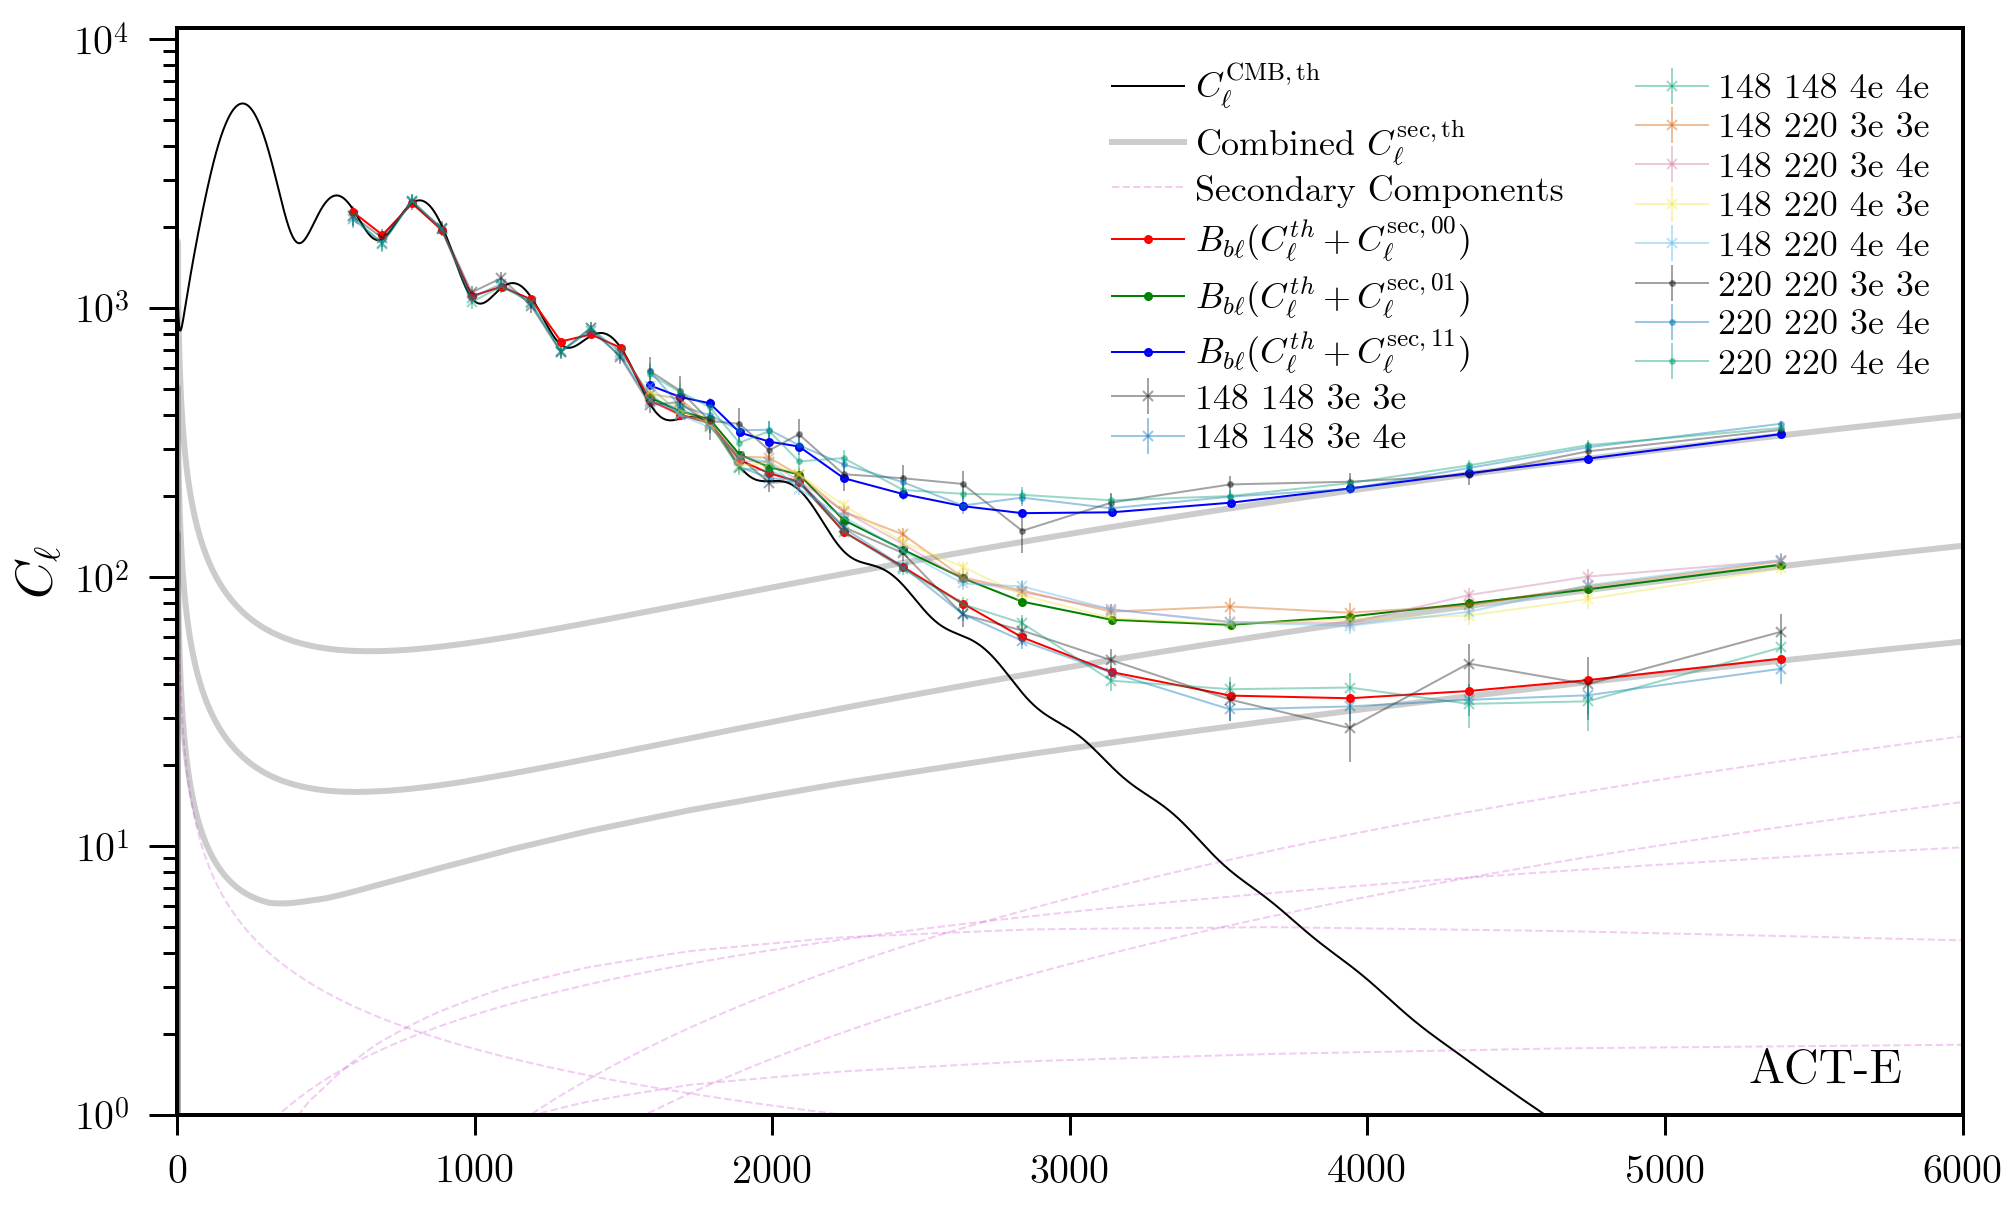

In [413]:
plt.figure(figsize=(16,10), facecolor='white')
s0 = spectra[cross_list[0]]
s1 = spectra[cross_list[-1]]

plt.plot(cl_th, 'k-', lw=1, alpha=1.0, label=r'$C^{\mathrm{CMB,th}}_{\ell}$')
plt.plot([],[],'k-', label=r'Combined $C^{\mathrm{sec,th}}_{\ell}$', alpha=0.2)
plt.plot([],[],'m--',label='Secondary Components', lw=1, alpha=0.2)
plt.plot(test_secondaries[0,0,:], 'k-', alpha=0.2)
plt.plot(test_secondaries[1,0,:], 'k-', alpha=0.2)
plt.plot(test_secondaries[1,1,:], 'k-', alpha=0.2)

for s in spectra:
    m = 'x' if s[0] == '148' else '.'
    plt.errorbar( spectra[s].ell, spectra[s].spectrum * spectra[s].ell**2 / 2 / np.pi, 
                 spectra[s].noise * spectra[s].ell**2 / 2 / np.pi, 
             label=' '.join(s), marker=m, lw=1, ms=5, markeredgewidth=1, alpha=0.4)
    

bincut = np.logical_and(bin_center > 500, bin_center < 6000) 
plt.plot( bin_center[bincut], (windows[cross_list[0]].window 
                               @ (cl_th + test_secondaries[0,0,:]))[bincut], 
         'r.-', lw=1, label="$B_{b\ell}(D_{\ell}^{th} + D_{\ell}^{\mathrm{sec},00})$" )
bincut = np.logical_and(bin_center > 1500, bin_center < 6000) 
plt.plot( bin_center[bincut], (windows[cross_list[0]].window 
                               @ (cl_th + test_secondaries[1,0,:]))[bincut], 
         'g.-', lw=1, label="$B_{b\ell}(D_{\ell}^{th} + D_{\ell}^{\mathrm{sec},01})$" )
plt.plot( bin_center[bincut], (windows[cross_list[0]].window 
                               @ (cl_th + test_secondaries[1,1,:]))[bincut], 
         'b.-', lw=1, label="$B_{b\ell}(D_{\ell}^{th} + D_{\ell}^{\mathrm{sec},11})$" )

for c in components:
    plot_par = test_par.copy()
    plot_par.update({'i':0, 'j':0})
    sec_out = c.model(148, 148, np.arange(l_max+1), **plot_par)
    plt.plot(sec_out, 'm--', lw=1, alpha=0.2)
    
    
plt.yscale("log")
plt.ylim(1e0,1.1e4)
plt.xlim(0, 6000)
plt.legend(ncol=2, fontsize=18, loc='upper right')
plt.text(0.88, 0.03, "ACT-E", fontsize=24, 
         transform=plt.gca().transAxes);
plt.ylabel(r'$D_{\ell}$')